<div style="background-color:#BFBEBE; text-align: center;">
<img src="imgs/icon.png" style="width:600px">
</div>

# Speech Gender Detection

O SINAL DE VOZ

### Conteúdo linguístico:
* linguagem
* semântica
* sotaque

### Conteúdo paralinguístico:
* identidade
* sexo
* idade
* estado emocional

### Outras informações:
* ambiente da gravação
* qualidade da gravação
* ruído
* canal de transmissão
* localização (mais de 1 canal)

---

As cordas vocais modulam o fluxo de ar, abrindo e fechando rapidamente a passagem pela laringe. Sua taxa de vibração é determinada principalmente por sua massa e tensão, embora a pressão e velocidade do ar também contribuam, em menor escala. Durante uma fala normal, a taxa de vibração das pregas vocais pode variar a uma razão de 2:1 (uma oitava).

## Freqüências típicas
* Homem: 110 Hz; 
* Mulher: 220 Hz; 
* Crianças: 300 Hz.

ref: [Física da Fala e da Audição](https://sites.ifi.unicamp.br/graduacao/files/2018/06/M%C3%B3dulo-09_A-Voz-Humana-I_Produ%C3%A7%C3%A3o-da-Fala.pdf)

In [ ]:
!curl https://meriatdatasets.blob.core.windows.net/public/digital-audio-processing/OSR_uk_000_0022_8k.wav -o audios/OSR_uk_000_0022_8k.wav
!curl https://meriatdatasets.blob.core.windows.net/public/digital-audio-processing/OSR_us_000_0019_8k.wav -o audios/OSR_us_000_0019_8k.wav
!curl https://meriatdatasets.blob.core.windows.net/public/digital-audio-processing/wrapping_paper.wav -o audios/wrapping_paper.wav

In [1]:
import os, sys, math
import argparse
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
from scipy import interpolate

In [2]:
def speech_vad(wav_file):
    fs, audio = wavfile.read(wav_file)
    audio = audio / 2.0 ** 14 # normalize in range (-2, +2)
    audio = audio - np.mean(audio)

    frame_size_ms = 25
    step_size_ms = 10
    frame_size_samples = int(fs * frame_size_ms / 1000)
    step_size_samples = int(fs * step_size_ms / 1000)
    number_of_frames = int((len(audio) - frame_size_samples) / step_size_samples)
    total_number_samples = int (
        (number_of_frames * step_size_ms + (frame_size_ms - step_size_ms)) * fs / 1000)
    audio = audio[0: total_number_samples] # remove the last partial frame
    n_fft_points = 2
    while n_fft_points < frame_size_samples:
        n_fft_points = n_fft_points *2
    pitch_low = 100  # Hz
    pitch_high = 300 # Hz
    hz_per_bin = fs / n_fft_points
    bin0 = int(pitch_low / hz_per_bin)
    bin1 = math.ceil(pitch_high / hz_per_bin) + 1
    energy_array=[]
    for i in np.arange(number_of_frames):
        pos0 = int(i * step_size_samples) 
        pos1 = int(pos0 + frame_size_samples)
        frame = audio[pos0 : pos1]
        f_audio = abs(np.fft.fft(frame, n=n_fft_points))/float(n_fft_points)
        energy_array.append(float(np.mean(f_audio[bin0 : bin1])))
    energy_array = np.array(energy_array)
    
    WT = 500 # ms: window size, treat it as silence if more than 0.5s
    L = int(WT/step_size_ms)
    noise = 1 << 31;
    for n in range(number_of_frames - L):
        m = np.mean(energy_array[n : (n+1)*L])
        if m < noise:
            noise = m

    masks = list(range(number_of_frames))
    threshold = 6 * noise # noise level, 20*log10(10) = 20dB, 20*log10(6) = 16dB
    if number_of_frames * step_size_ms < 6*WT: # too short to find silence noise
        a = np.amin(energy_array)
        b = np.amax(energy_array)
        c = a + (b-a) * 1.0/3.0
        if threshold > c:
            threshold = c

    for i in range(number_of_frames):
        if energy_array[i] > threshold:
            masks[i] = 1
        else:
            masks[i] = 0

    # check 0s
    f0 = 0
    for f in range(number_of_frames):
        if masks[f] > 0:
            f0 = f
            break
    c = 0
    temp = []
    for fm in range(f0, number_of_frames):
        if masks[fm] > 0:
            if c == 0:
                continue
            if c > 0:
                temp.append(fm) # 2nd
                c = 0;
        else:
            if c == 0:
                temp.append(fm) # 1st
            c += 1
    for i in range(int(len(temp)/2)):
        p1 = temp[2*i+0]
        p2 = temp[2*i+1]
        if p2 - p1 < L: # not silence
            for p in range(p1, p2+1):
                masks[p] = 1
    # check 1s
    c = 0
    temp = []
    for fm in range(number_of_frames):
        if masks[fm] < 1:
            if c == 0:
                continue
            if c > 0:
                temp.append(fm) # 2nd
                c = 0;
        else:
            if c == 0:
                temp.append(fm) # 1st
            c += 1
    for i in range(int(len(temp)/2)):
        p1 = temp[2*i+0]
        p2 = temp[2*i+1]
        if p2 - p1 < int(L/5): # not active
            for p in range(p1, p2+1):
                masks[p] = 0

    vad_masks = np.repeat(masks, step_size_samples)
    return (audio[0:len(vad_masks)], vad_masks, fs)

In [3]:
def speech_pitch(wav_file):

    audio, vad_masks, fs = speech_vad(wav_file)

    frame_size_ms = 25*2
    step_size_ms = 10
    frame_size_samples = int(fs * frame_size_ms / 1000)
    step_size_samples = int(fs * step_size_ms / 1000)
    number_of_frames = int((len(audio) - frame_size_samples) / step_size_samples)
    total_number_samples = int ((number_of_frames * step_size_ms 
                                 + (frame_size_ms - step_size_ms)) * fs / 1000)
    audio = audio[0: total_number_samples] # remove the last partial frame
    n_fft_points = 2
    while n_fft_points < frame_size_samples:
        n_fft_points = n_fft_points *2
    while(n_fft_points * 5 < fs): # no more than 10 Hz per freq bin
        n_fft_points = n_fft_points*2
    pitch_low = 0  # Hz
    pitch_high = 500 # Hz
    hz_per_bin = fs / n_fft_points
    b0 = int(pitch_low / hz_per_bin)
    b1 = math.ceil(pitch_high / hz_per_bin) + 1
    energy_array=[]
    for i in np.arange(number_of_frames):
        pos0 = int(i * step_size_samples) 
        pos1 = int(pos0 + frame_size_samples)
        frame = audio[pos0 : pos1]
        f_audio = abs(np.fft.fft(frame, n=n_fft_points))/float(n_fft_points)
        energy_array.append(np.array(list(f_audio[b0 : b1])))
    energy_array = np.array(energy_array)

    filter_bank = np.zeros(b1-b0, dtype = float)
    for i in np.arange(number_of_frames):
        m = i * step_size_samples
        n = i * step_size_samples + int(frame_size_samples)
        if vad_masks[m] > 0 and vad_masks[n] > 0:
            filter_bank = filter_bank + energy_array[i]
    xf = np.arange(0, len(filter_bank), 1) * fs / n_fft_points
    x = np.arange(0, len(filter_bank), 1) * fs / n_fft_points
    y = filter_bank
    x2 = np.arange(0, len(filter_bank), 0.2) * fs / n_fft_points 
    z = np.polyfit(x, y, 15)
    p = np.poly1d(z)
    y2 = p(x2)
    
    f_low = 85 # Hz
    f_high = 285 # Hz
    idx1 = int(f_low / fs * n_fft_points)
    idx2 = int(f_high / fs * n_fft_points)
    maxm = np.amax(filter_bank[0 : idx1])
    F0 = 0
    for i in np.arange(idx1, (idx2 - idx1), 1):
        if (filter_bank[i] > 1.25*maxm and filter_bank[i] > filter_bank[i-1]
            and filter_bank[i] > filter_bank[i+1]):
            F0 = int(i * (fs / n_fft_points))
            break
    gender = 'Unknown'
    if 85 <= F0 < 170:     # [85, 170)
        gender = 'Male'
    elif 170 <= F0 < 255: # [170, 255]
        gender = 'Female'

    return (audio[0:len(vad_masks)], vad_masks, fs, filter_bank, n_fft_points, F0, gender)

In [4]:
def plot_pitch(audio, vad_masks, fs, filter_bank, fft_points, F0, gender):
    # pitch estimation and gender detection
    xt = np.arange(0, len(audio), 1) / fs *1000
    xf = np.arange(0, len(filter_bank), 1) * fs / fft_points 

    plt.figure(figsize=(16,8))
    plt.subplot(2, 1, 1)
    plt.plot(xt, audio)
    plt.xlabel('time (ms)')
    plt.ylabel('amplitude')
    plt.title('audio signal')

    plt.subplot(2, 1, 2)
    plt.plot(xf, filter_bank)
    plt.axvline(x=F0,color='red')
    plt.axvline(x=170,color='black',linestyle='dashed')
    plt.xlabel('frequency (Hz)')
    plt.ylabel('magnitude')
    textstr = f'\nPitch: {str(F0)} Gender: {gender}'
    plt.title('pitch estimation')

    plt.tight_layout()
    plt.show()

In [14]:
%%time 

audio_file = 'audios/OSR_us_000_0019_8k.wav'
audio, vad_masks, fs, filter_bank, fft_points, F0, gender = speech_pitch(audio_file)
print(gender)

Female
CPU times: user 191 ms, sys: 2.99 ms, total: 194 ms
Wall time: 201 ms


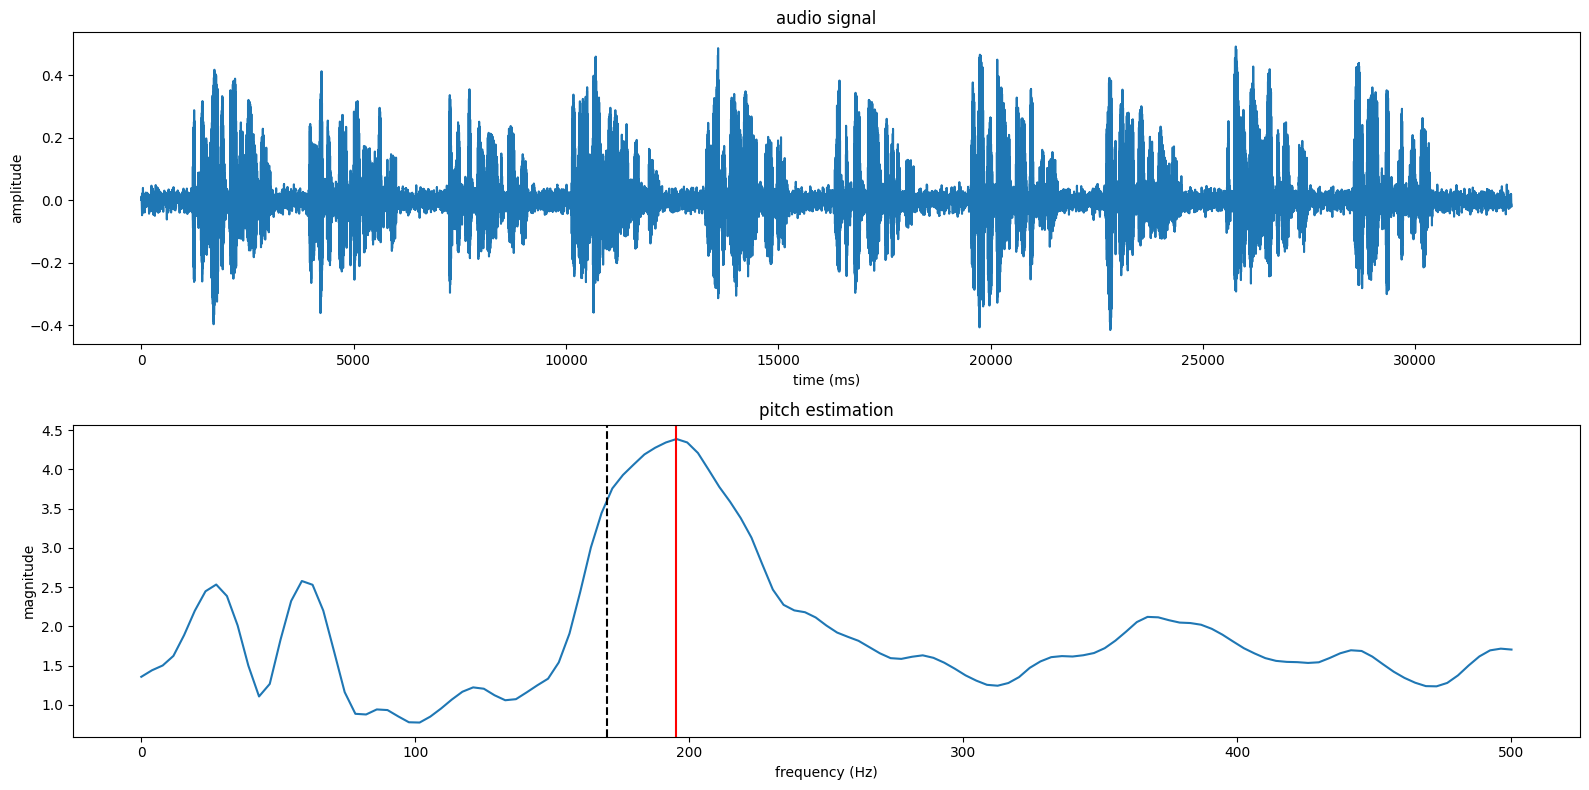

In [15]:
plot_pitch(audio, vad_masks, fs, filter_bank, fft_points, F0, gender)

In [16]:
%%time 

audio_file = 'audios/OSR_us_000_0035_8k.wav'
audio, vad_masks, fs, filter_bank, fft_points, F0, gender = speech_pitch(audio_file)
print(gender)

Male
CPU times: user 231 ms, sys: 750 μs, total: 231 ms
Wall time: 243 ms


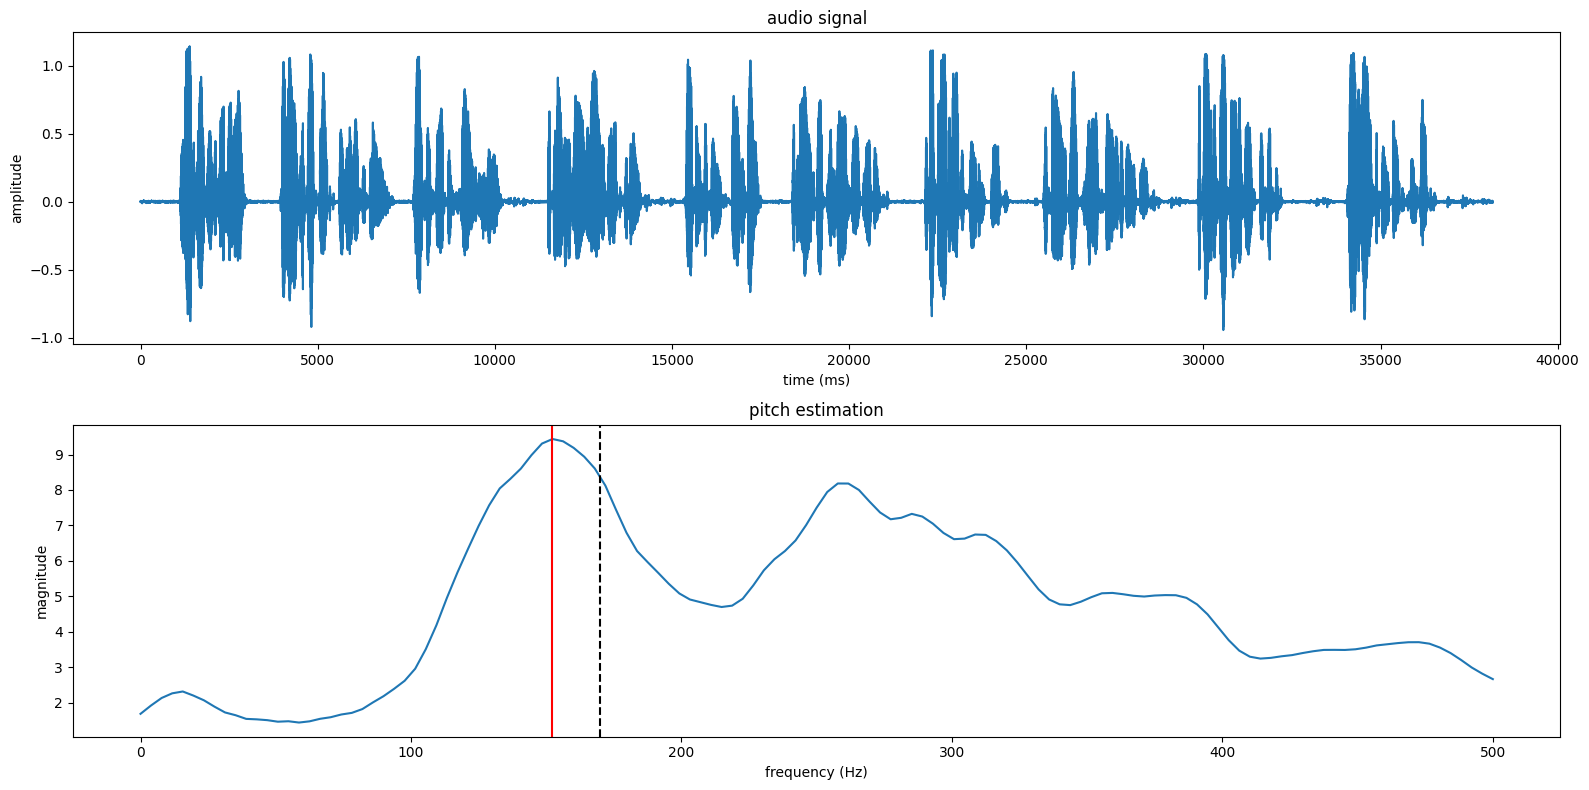

In [17]:
plot_pitch(audio, vad_masks, fs, filter_bank, fft_points, F0, gender)

In [19]:
%%time 

audio_file = 'audios/oboe_c6.wav'
audio, vad_masks, fs, filter_bank, fft_points, F0, gender = speech_pitch(audio_file)
print(gender)

Unknown
CPU times: user 20.6 ms, sys: 6.29 ms, total: 26.9 ms
Wall time: 44.5 ms


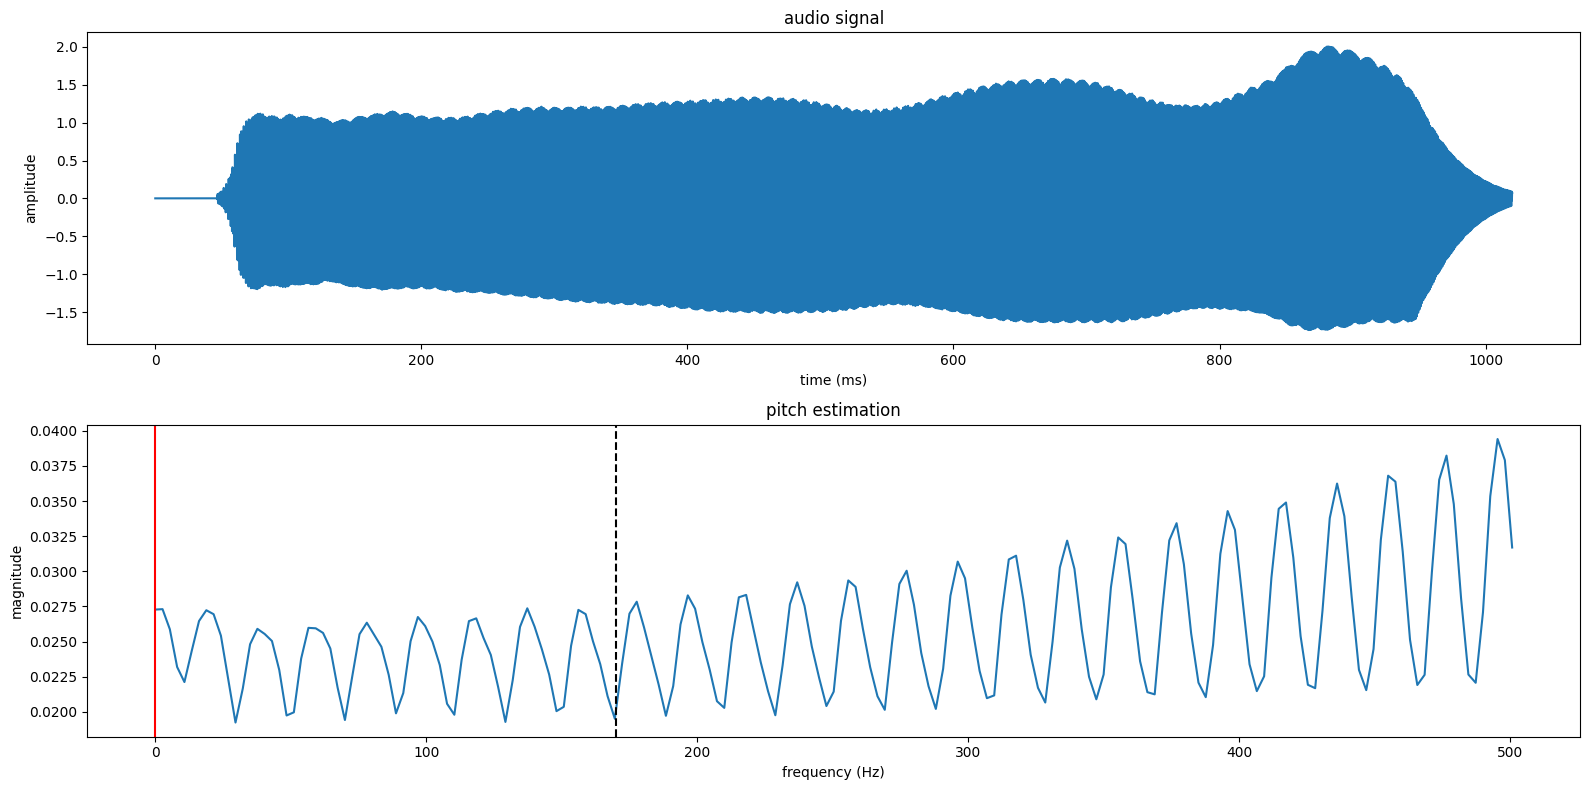

In [20]:
plot_pitch(audio, vad_masks, fs, filter_bank, fft_points, F0, gender)